In [2]:
import sys
import os


# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [12]:
# building the portfolio with the necessary packages
import datetime
import numpy as np
import pandas as pd

from portfolio import build_portfolio

start_date = datetime.datetime(2015, 12, 1)
end_date = "2015-12-31"

d = {
    0: {"Name": "GOOG", "Allocation": 20},
    1: {"Name": "AMZN", "Allocation": 10},
    2: {"Name": "MCD", "Allocation": 15},
    3: {"Name": "DIS", "Allocation": 18},
    4: {"Name": "MSFT", "Allocation": 20},
    5: {"Name": "JNJ", "Allocation": 17}

}


pf_allocation = pd.DataFrame.from_dict(d, orient="index")
names = pf_allocation["Name"].values.tolist()

pf = build_portfolio(
    names=names,
    pf_allocation=pf_allocation,
    start_date=start_date,
    end_date=end_date,
    data_api="yfinance",
    # market_index=market_index
)

R = pf.comp_mean_returns()
Sigma = pf.comp_cov()*252

sp_ratio = pf.comp_sharpe()

d:\Guided quantum walk for portfolio optimization\main\portfolio.py:263: FutureWarning: YF.download() has changed argument auto_adjust default to True
  res: pd.DataFrame = yfinance.download(names, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed


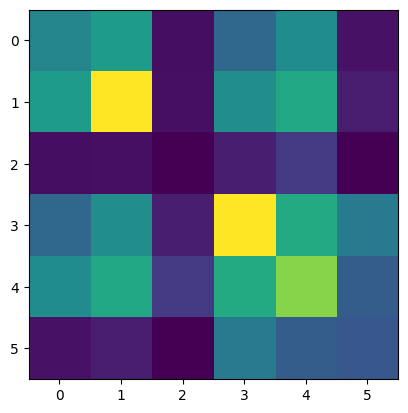

In [4]:
import matplotlib.pyplot as plt
plt.imshow(Sigma, interpolation='nearest')
plt.show()

In [13]:
# form the qubo problem

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo

gamma = 0.5
B = 3
portfolio = PortfolioOptimization(expected_returns=np.array(R), covariances=np.array(Sigma), risk_factor=gamma, budget=B)
qp = portfolio.to_quadratic_program()

qubo_conv = QuadraticProgramToQubo()
qubo_prob = qubo_conv.convert(qp)

cost_op = qubo_prob.to_ising()[0]

In [14]:
# classical solution using numpy minimum eigen solver

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver =  MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qubo_prob)
print(result.prettyprint())

objective function value: -0.8867915929003374
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0
status: SUCCESS


In [15]:
# This is quantum solution with the well known QAOA algorithm with the standard qiskit implementation

from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA 

cobyla = COBYLA()
cobyla.set_options(max_steps = 250)
sampler = StatevectorSampler()
qaoa = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
optimizer = MinimumEigenOptimizer(qaoa)
result1 = optimizer.solve(qp) 

d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\qiskit_algorithms\optimizers\scipy_optimizer.py:162: OptimizeWarning: Unknown solver options: max_steps
  raw_result = minimize(
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [16]:
print(result1.prettyprint())

objective function value: -0.8867915929003412
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0
status: SUCCESS


In [18]:
# this is locally developed referenced qiskit's algorithm structure quantum algorithm called `guided quantumw walk`

from qiskit_aer.primitives import SamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import NELDER_MEAD, COBYLA

from gqw_solver import GQW
nelder_mead = COBYLA()
nelder_mead.set_options(max_steps = 250)

gqw = GQW(sampler = StatevectorSampler(), optimizer=nelder_mead, reps = 3, time = 10)

optimizer = MinimumEigenOptimizer(gqw)
result = optimizer.solve(qp)


d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\qiskit_algorithms\optimizers\scipy_optimizer.py:162: OptimizeWarning: Unknown solver options: max_steps
  raw_result = minimize(
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [19]:
print(result.prettyprint())

objective function value: -0.8867915929003412
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0
status: SUCCESS
